In [173]:
from textblob import TextBlob
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
import nltk

In [168]:
# otd = pd.read_csv("Pathos_data_April30.csv", index_col = 0)
# otd
#import data （Yicong)
#otd= spark.read.csv('Pathos_data_April30.csv',header = 'True',inferSchema='True')

#Import Data (Sean)
otd = pd.read_csv("~/Downloads/Pathos_430.csv", index_col = 0)
otd = spark.createDataFrame(otd)

In [172]:
otd.toPandas().to_csv('Downloads/my_otd_original_test.csv')

In [171]:
otd.dtypes

[('Date', 'string'),
 ('Time', 'string'),
 ('Company Name', 'string'),
 ('Current Feelings', 'string'),
 ('Future Expectations', 'string'),
 ('Need Now', 'string'),
 ('City', 'string'),
 ('Expect_recovery', 'string'),
 ('Change_In_Life', 'string')]

In [174]:
# shape of data
print((otd.count(), len(otd.columns)))

(302, 9)


In [175]:
from pyspark.sql.functions import isnan, when, count, col
# check null values
otd.select([count(when(isnan(c), c)).alias(c) for c in otd.columns]).show()

+----+----+------------+----------------+-------------------+--------+----+---------------+--------------+
|Date|Time|Company Name|Current Feelings|Future Expectations|Need Now|City|Expect_recovery|Change_In_Life|
+----+----+------------+----------------+-------------------+--------+----+---------------+--------------+
|   0|   0|           0|               0|                  0|       0|   0|              0|             0|
+----+----+------------+----------------+-------------------+--------+----+---------------+--------------+



Changing the Datetime data type

In [176]:
#otd['Datetime'] = pd.to_datetime(otd['Date'] + ' ' +  otd['Time'])
import pyspark.sql.functions as F
split_col = F.split(otd['Date'], '-')
otd = otd.withColumn('Day', split_col.getItem(0))
otd = otd.withColumn('Month', split_col.getItem(1))
otd = otd.withColumn('Year', split_col.getItem(2))

otd=otd.withColumn("Date", F.to_date(F.concat_ws("-", "Year", "Month", "Day")) )
col_reorder = ['Date', 'Company Name', 'Current Feelings', 'Future Expectations', 'Need Now',
              'City', 'Expect_recovery','Change_In_Life']
otd = otd[col_reorder]

In [13]:
# Check the data shape of dataframe and null values
# from pyspark.sql.functions import isnan
# print (otd.count())
# otd.isnan().sum()

In [177]:
otd.show()

+----------+--------------------+--------------------+--------------------+--------------------+------------+----------------+--------------+
|      Date|        Company Name|    Current Feelings| Future Expectations|            Need Now|        City| Expect_recovery|Change_In_Life|
+----------+--------------------+--------------------+--------------------+--------------------+------------+----------------+--------------+
|2020-04-15|  baseH technologies|i am feeling not ...|hopefully all thi...|    the world to run|     karachi|        3 months|     No Change|
|2020-04-15|              Amazim|            Not good|          Don't know|              Relief|       Delhi|        6 months|     No Change|
|2020-04-15|            Citibank|I feel rarely tha...|                 Bad|             Freedom|      Austin|          1 year|     No Change|
|2020-04-15|   Noshn Advertising|       uncomfortable|wont be the same ...|               Money|      Kuwait|          1 year|     No Change|
|2020-

### Nature Language Process

In [178]:
# *** Import pakages for NLP ***
from pyspark.ml.feature import CountVectorizer,StringIndexer, RegexTokenizer,StopWordsRemover
from pyspark.sql.functions import col, udf,regexp_replace,isnull
from pyspark.sql.types import StringType,IntegerType
#pip install wordcloud
from wordcloud import WordCloud
import nltk
import os

In [179]:
# sotd = spark.read.csv('Pathos_data_April30.csv', header = 'True', inferSchema ='True')
sotd = otd

In [180]:
#sotd = spark.createDataFrame(otd)
sotd.columns

['Date',
 'Company Name',
 'Current Feelings',
 'Future Expectations',
 'Need Now',
 'City',
 'Expect_recovery',
 'Change_In_Life']

In [181]:
sotd.show()

+----------+--------------------+--------------------+--------------------+--------------------+------------+----------------+--------------+
|      Date|        Company Name|    Current Feelings| Future Expectations|            Need Now|        City| Expect_recovery|Change_In_Life|
+----------+--------------------+--------------------+--------------------+--------------------+------------+----------------+--------------+
|2020-04-15|  baseH technologies|i am feeling not ...|hopefully all thi...|    the world to run|     karachi|        3 months|     No Change|
|2020-04-15|              Amazim|            Not good|          Don't know|              Relief|       Delhi|        6 months|     No Change|
|2020-04-15|            Citibank|I feel rarely tha...|                 Bad|             Freedom|      Austin|          1 year|     No Change|
|2020-04-15|   Noshn Advertising|       uncomfortable|wont be the same ...|               Money|      Kuwait|          1 year|     No Change|
|2020-

Stemming

In [182]:
from pyspark.sql.functions import monotonically_increasing_id

sotd_to_stem = sotd["Current Feelings","Future Expectations","Need Now"]
cols_for_stem = ["Current Feelings","Future Expectations","Need Now"]
df_stem = []
for colu in cols_for_stem:
    col_name = str (colu + "_Stem")
    regex_tokenizer = RegexTokenizer(inputCol = colu, outputCol= col_name, pattern="\\W")
    raw_words = regex_tokenizer.transform(sotd_to_stem.select(colu))
    df_stem.append(raw_words)
    
    
df_1 = df_stem[0].withColumn("id", monotonically_increasing_id())
df_2 = df_stem[1].withColumn("id", monotonically_increasing_id())
df_3 = df_stem[2].withColumn("id", monotonically_increasing_id())
df_complete = df_1.join(df_2, "id","outer").join(df_3, "id", "outer").drop("id")


df_complete = df_complete.select(col("Current Feelings_Stem").alias("curr_stem"),
                                 col("Future Expectations_Stem").alias("future_stem"),
                                 col("Need Now_Stem").alias("now_stem"))

df_complete.show()

+--------------------+--------------------+--------------------+
|           curr_stem|         future_stem|            now_stem|
+--------------------+--------------------+--------------------+
| [sad, and, anxious]|[the, future, wil...|[economic, impact...|
|        [reflective]|[it, is, going, t...|[elderly, in, fam...|
|         [concerned]|[highly, controll...|[business, growth...|
|[manageable, if, ...|[good, everyone, ...|[i, am, essential...|
|[i, am, an, intro...|[maybe, we, don, ...|[well, business, ...|
|               [sad]|            [gloomy]|             [money]|
|           [anxious]|[a, more, closed,...|[how, long, this,...|
|[i, am, feeling, ...|[hopefully, all, ...|[the, world, to, ...|
|              [shit]|             [blank]|        [everything]|
|[connected, but, ...|[it, s, going, to...|[how, do, i, go, ...|
| [not, fully, relax]|              [cool]|[prepare, for, to...|
|           [anxious]|[positive, long, ...|              [work]|
|[sad, but, patience]|   

In [183]:
def lemma(x):
    nltk.download('wordnet')
    from nltk.stem import WordNetLemmatizer
    lemmatizer = WordNetLemmatizer()
    return lemmatizer.lemmatize(x)



from nltk.corpus import stopwords
StopWords = stopwords.words('english')

col_to_wiz = ['curr_stem', 'future_stem','now_stem']
df_lst =[]
for column in col_to_wiz:
    curr = df_complete.rdd.map(lambda x: x[column]).filter(lambda x: x is not None)
    token = curr\
             .map(lambda word: [x for x in word if x.isalpha()])\
             .map(lambda word: [x for x in word if len(x) >= 3])\
             .map(lambda word: [x for x in word if x not in StopWords])\
             .map(lambda word: [lemma(x) for x in word])\
             .map(lambda word: [str(TextBlob(x).correct()) for x in word])
    temp = spark.createDataFrame([[l] for l in token.collect()], [column])
    df_lst.append(temp)


In [21]:
#from pyspark.sql.functions import monotonically_increasing_id
df_1 = df_lst[0].withColumn("id", monotonically_increasing_id())
df_2 = df_lst[1].withColumn("id", monotonically_increasing_id())
df_3 = df_lst[2].withColumn("id", monotonically_increasing_id())
new_complete = df_1.join(df_2, "id","outer").join(df_3, "id", "outer").drop("id")
new_complete.show()

+--------------------+--------------------+--------------------+
|           curr_stem|         future_stem|            now_stem|
+--------------------+--------------------+--------------------+
|              [good]|             [bleak]|[would, able, sur...|
|[effective, grate...|[optimism, believ...|[work, housing, i...|
|[exhausted, gathe...|[hope, everything...|             [money]|
|            [scared]|  [going, difficult]|               [end]|
|          [confused]|   [health, finance]|   [health, finance]|
|[energies, anxiou...|[cautiously, opti...|       [losing, job]|
|[exhausted, irrit...|[nothing, coming,...|         [get, home]|
|      [sad, anxious]|[future, altered,...|[economic, impact...|
|    [calm, grateful]|           [hopeful]|[everyone, one, f...|
|               [bad]|             [risky]|      [people, life]|
| [anxious, restless]|     [thing, change]|               [hit]|
|[quite, distressful]|[thing, seem, ble...|[physically, chal...|
|      [enthusiastic]|[sh

#### Word Frequency

In [184]:
def wordCount(word):
    return (word.groupBy('corrected').count())

def correct_text (word):
    if len(word) > 2:
        return str(TextBlob(word).correct())
    else:
        return None

correct_udf = udf(correct_text)

In [185]:
from pyspark.sql.functions import split, explode, col
## Current Feeling Corpus:
new_complete.select(new_complete.columns[0]).collect()
curr_word = new_complete.select(col("curr_stem"))
curr_word = curr_word.select(explode(curr_word.curr_stem).alias('word'))
curr_word = curr_word.withColumn('corrected', correct_udf('word')).dropna()

curr_word_freq = wordCount(curr_word).orderBy('count', ascending = False)
curr_word_freq.show()

+---------+-----+
|corrected|count|
+---------+-----+
|  anxious|   41|
|uncertain|   22|
|      sad|   20|
|concerned|   17|
|      bad|   15|
|     good|   14|
|  worried|   13|
|      bit|   12|
|  feeling|   12|
|   little|   11|
|     time|   10|
|   future|   10|
|     feel|    9|
|    bored|    7|
| stressed|    7|
|     like|    6|
|   really|    6|
|    world|    6|
|   people|    6|
|      end|    6|
+---------+-----+
only showing top 20 rows



In [186]:
# Future expr Corpus
future_word = new_complete.select(col("future_stem"))
future_word = future_word.select(explode(future_word.future_stem).alias('word'))
future_word = future_word.withColumn('corrected', correct_udf('word')).dropna()

future_word_freq = wordCount(future_word).orderBy('count', ascending = False)
future_word_freq.show()

+----------+-----+
| corrected|count|
+----------+-----+
|  positive|   23|
|    future|   20|
|      time|   20|
|optimistic|   20|
|     going|   18|
|       get|   18|
| uncertain|   18|
|    better|   17|
|     thing|   16|
|    normal|   14|
|    change|   11|
|      back|   10|
|    people|   10|
|      hope|   10|
|       new|   10|
|     world|   10|
|      sure|   10|
|     bleak|   10|
|      term|    9|
|      take|    9|
+----------+-----+
only showing top 20 rows



In [187]:
# Need Now Corpus:
now_word = new_complete.select(col("now_stem"))
now_word = now_word.select(explode(now_word.now_stem).alias('word'))
now_word = now_word.withColumn('corrected', correct_udf('word')).dropna()

now_word_freq = wordCount(now_word).orderBy('count', ascending = False)
now_word_freq.show()

+-----------+-----+
|  corrected|count|
+-----------+-----+
|     health|   42|
|        job|   38|
|     family|   28|
|   security|   26|
|  financial|   18|
|     safety|   17|
|    economy|   15|
|   economic|   15|
|     people|   14|
|       life|   13|
|        one|   12|
|       work|   12|
|   business|   12|
|        end|   11|
|      money|   10|
|uncertainty|   10|
|       food|   10|
|     impact|    9|
|    concern|    9|
|     normal|    9|
+-----------+-----+
only showing top 20 rows



In [ ]:
# from pyspark.sql import Row
# rowrdd = token_complete.map(lambda x: Row(data = x))
# temp = spark.createDataFrame(rowrdd)

In [ ]:
# temp.show()

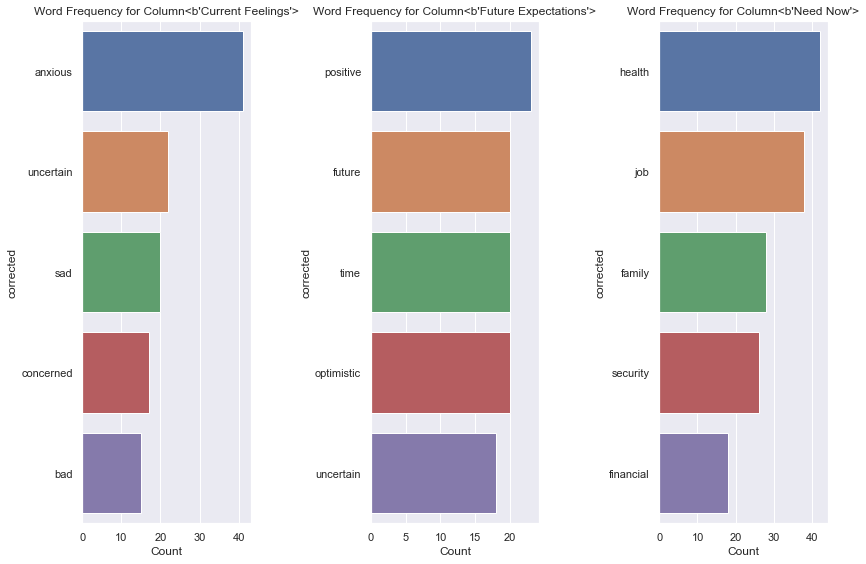

In [188]:
# Draw the histogram for Word Frequency in each documents

import seaborn as sns


pd_curr_word_freq = curr_word_freq.toPandas().sort_values('count', ascending = False).head(5)
pd_future_word_freq = future_word_freq.toPandas().sort_values('count', ascending = False).head(5)
pd_now_word_freq = now_word_freq.toPandas().sort_values('count', ascending = False).head(5)

fig, axes = plt.subplots(nrows = 1, ncols = 3, figsize = (12,8))
wc_df_lst = [pd_curr_word_freq, pd_future_word_freq,pd_now_word_freq]

txt_lst = sotd["Current Feelings","Future Expectations","Need Now"]
i = 0


for txt in txt_lst:
    plt.subplot(1,3,i+1)
    sns.barplot(y="corrected", x="count",data=wc_df_lst[i])
    sns.set(rc = {'figure.figsize': (8,6)})
    plt.xlabel("Count")
    plt.title("Word Frequency for %s" %txt_lst[i])
    display()
    i += 1

plt.tight_layout()
#plt.subplots_adjust(wspace =3, hspace =3)

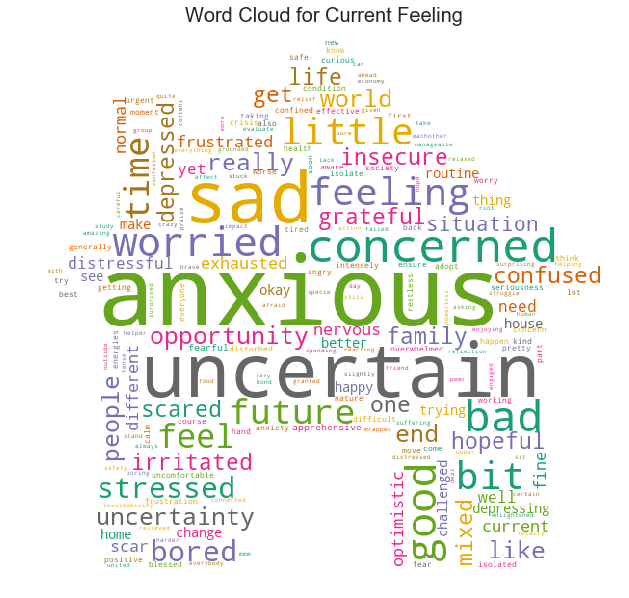

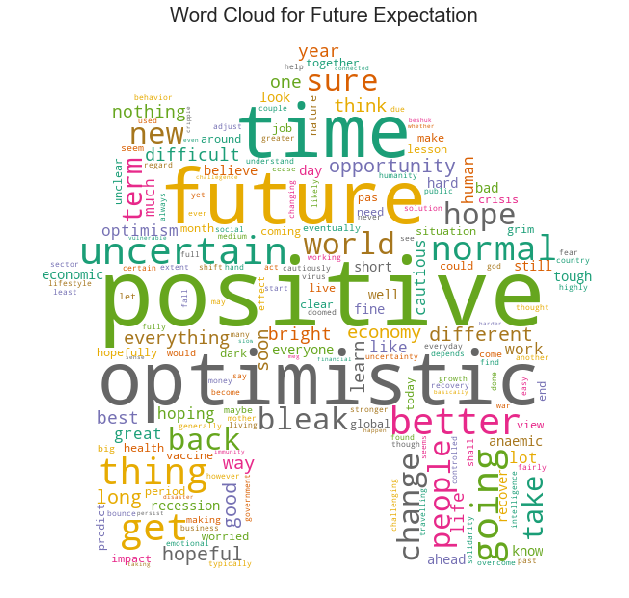

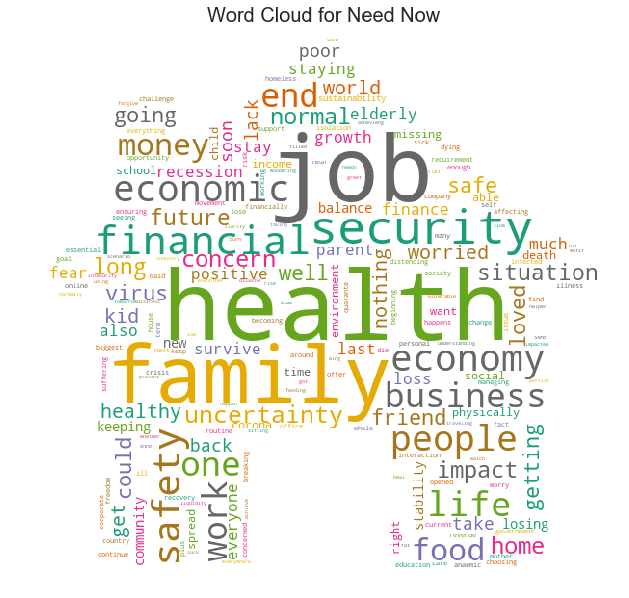

In [189]:
# Draw the Word Clouds
import matplotlib.pyplot as plt
import wordcloud
from wordcloud import WordCloud
from PIL import Image
import numpy as np
import urllib
import requests

shelter_mask = np.array(Image.open(requests.get('http://www.clker.com/cliparts/O/i/x/Y/q/P/yellow-house-hi.png', stream=True).raw))

pd_curr_word_freq = curr_word_freq.toPandas()
pd_future_word_freq = future_word_freq.toPandas()
pd_now_word_freq = now_word_freq.toPandas()
dfs = [pd_curr_word_freq, pd_future_word_freq,pd_now_word_freq]

title_lst = ['Current Feeling', 'Future Expectation', 'Need Now']
i =0

for curr_df in dfs:
    wc_df = curr_df.set_index('corrected').T.to_dict('records')
    
    wordcloud_cur = WordCloud(width=500, 
                          height=500, 
                          random_state=30, 
                          max_font_size=100, 
                          relative_scaling=0.5, 
                          colormap='Dark2', 
                          background_color = 'white', 
                          mask = shelter_mask).generate_from_frequencies(dict(*wc_df))
    plt.figure(figsize=(14, 10),facecolor = 'white', edgecolor='blue')    
    plt.title("Word Cloud for %s" %title_lst[i],fontsize=20)
    plt.imshow(wordcloud_cur) #interpolation="bilinear")
    plt.axis('off')
    plt.show()
    display()
    i += 1

In [24]:
# pd_curr_word_freq = curr_word_freq.toPandas()
# pd_future_word_freq = future_word_freq.toPandas()
# pd_now_word_freq = now_word_freq.toPandas()
# dfs = [pd_curr_word_freq, pd_future_word_freq,pd_now_word_freq]

# title_lst = ['Current Feeling', 'Future Expectation', 'Need Now']

# for curr_df in dfs:
#     i = 0
#     wc_df = curr_df.set_index('corrected').T.to_dict('records')

#     wordcloud_cur = WordCloud(width=800, height=500, random_state=21, max_font_size=100, relative_scaling=0.5, colormap='Dark2').generate_from_frequencies(dict(*wc_df))

#     plt.figure(figsize=(14, 10))
#     plt.title("Word Cloud for %s" %title_lst[i])
#     plt.imshow(wordcloud_cur, interpolation="bilinear")
#     plt.axis('off')
#     plt.show()
#     display()
#     i += 1

### Scoring Emotions

In [190]:
# pip install vaderSentiment
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer
analyzer = SentimentIntensityAnalyzer()

# def sa_score (sentence):
#     score = analyser.polarity_scores(sentence)
#     #print (score)
#     return score

In [191]:
from pyspark.sql.functions import udf
from pyspark.sql.types import *
# nltk.download('vader_lexicon')
# from nltk.sentiment.vader import SentimentIntensityAnalyzer
# analyzer = SentimentIntensityAnalyzer() 

def udf_po(text):
    score = analyzer.polarity_scores(text)
    for (k,v) in score.items():
            if k == 'compound':
                return v

# NOTE: it seems that calls to udf() must be after SparkContext() is called
udfValueToPo = udf(udf_po, FloatType())

In [192]:
otd = otd.withColumn("Current Feelings com_score", udfValueToPo("Current Feelings"))
otd = otd.withColumn("Future Exp com_score", udfValueToPo("Future Expectations"))

In [193]:
otd=otd.withColumnRenamed('Company Name','Com_name')
otd=otd.withColumnRenamed('Current Feelings','Curr_feels')
otd=otd.withColumnRenamed('Future Expectations','Future_exp')
otd=otd.withColumnRenamed('Need Now','Need_now')
otd=otd.withColumnRenamed('Current Feelings com_score','Curr_score')
otd=otd.withColumnRenamed('Future Exp com_score','Future_score')

In [194]:
otd.createOrReplaceTempView('otd')

In [195]:
# Find out the number of records in diff days
from pyspark.sql.functions import month, dayofmonth

Num_of_record = otd.groupBy(month('Date'), dayofmonth('Date')).count().orderBy('month(Date)','dayofmonth(Date)')
Num_of_record.show()

+-----------+----------------+-----+
|month(Date)|dayofmonth(Date)|count|
+-----------+----------------+-----+
|          4|              15|   86|
|          4|              16|    9|
|          4|              19|    2|
|          4|              20|    6|
|          4|              21|   27|
|          4|              22|   25|
|          4|              23|   31|
|          4|              24|   31|
|          4|              25|   21|
|          4|              26|   35|
|          4|              27|   14|
|          4|              28|    5|
|          4|              29|    3|
|          4|              30|    6|
|          5|               1|    1|
+-----------+----------------+-----+



In [196]:
sotd_with_label1 = spark.sql("""
SELECT * , CASE WHEN (Curr_score < 0 AND Future_score > 0.5) THEN "with_big_hope"
                WHEN (Curr_score < 0 AND Future_score between 0 and 0.5) THEN "with_little_hope"
                WHEN (Curr_score < 0 AND Future_score < 0) THEN "pessimisitcs"
                WHEN (Curr_score >= 0 AND Future_score >= 0) THEN "optimistics"
                WHEN (Curr_score >= 0 AND Future_score < 0) THEN "holpless"
                ELSE "neutral"
                END AS Label
                FROM otd
""")
sotd_with_label1.show()

+----------+--------------------+--------------------+--------------------+--------------------+------------+----------------+--------------+----------+------------+----------------+
|      Date|            Com_name|          Curr_feels|          Future_exp|            Need_now|        City| Expect_recovery|Change_In_Life|Curr_score|Future_score|           Label|
+----------+--------------------+--------------------+--------------------+--------------------+------------+----------------+--------------+----------+------------+----------------+
|2020-04-15|  baseH technologies|i am feeling not ...|hopefully all thi...|    the world to run|     karachi|        3 months|     No Change|   -0.2278|      0.6808|   with_big_hope|
|2020-04-15|              Amazim|            Not good|          Don't know|              Relief|       Delhi|        6 months|     No Change|   -0.3412|         0.0|with_little_hope|
|2020-04-15|            Citibank|I feel rarely tha...|                 Bad|          

In [197]:
sotd_with_label = spark.sql("""
select substring(a.Date,6,5) as date, a.label, count(*) as cnts
from
(SELECT Date , CASE WHEN (Curr_score < 0 AND Future_score > 0.5) THEN "with_big_hope"
                WHEN (Curr_score < 0 AND Future_score between 0 and 0.5) THEN "with_little_hope"
                WHEN (Curr_score < 0 AND Future_score < 0) THEN "pessimisitcs"
                WHEN (Curr_score >= 0 AND Future_score >= 0) THEN "optimistics"
                WHEN (Curr_score >= 0 AND Future_score < 0) THEN "holpless"
                ELSE "neutral"
                END AS Label
                FROM otd) a
group by substring(a.Date,6,5),a.label
order by substring(a.Date,6,5),a.label
""")
sotd_with_label.show()

+-----+----------------+----+
| date|           label|cnts|
+-----+----------------+----+
|04-15|        holpless|   7|
|04-15|     optimistics|  17|
|04-15|    pessimisitcs|  17|
|04-15|   with_big_hope|  11|
|04-15|with_little_hope|  34|
|04-16|     optimistics|   3|
|04-16|    pessimisitcs|   6|
|04-19|    pessimisitcs|   2|
|04-20|        holpless|   1|
|04-20|    pessimisitcs|   1|
|04-20|with_little_hope|   4|
|04-21|        holpless|   4|
|04-21|     optimistics|   6|
|04-21|    pessimisitcs|   6|
|04-21|   with_big_hope|   4|
|04-21|with_little_hope|   7|
|04-22|        holpless|   3|
|04-22|     optimistics|   5|
|04-22|    pessimisitcs|   7|
|04-22|   with_big_hope|   4|
+-----+----------------+----+
only showing top 20 rows



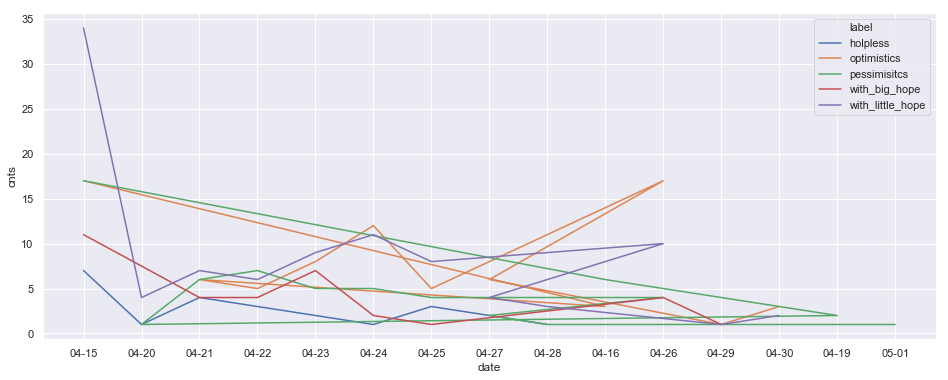

In [198]:
sotd_with_label_pd1 = sotd_with_label.toPandas()
fig, ax = plt.subplots(figsize=(16, 6))
a=sns.lineplot(data=sotd_with_label_pd1, x='date', y='cnts', hue='label')

In [199]:
## Alignning the Unit of Time 
#otd_w_label = sotd_with_label1.toPandas()
sotd_with_label1.createOrReplaceTempView('otd_w_label')

otd_w_labels = spark.sql("""
SELECT *, CASE WHEN (Expect_recovery = '3 months') or (Expect_recovery = 'Three months at least') THEN '3 Months'
                WHEN Expect_recovery = '1 month' THEN '1 Month'
                WHEN Expect_recovery = '6 months' THEN 'Half Year'
                WHEN Expect_recovery in ('1 year','A year') THEN 'A Year'
                WHEN Expect_recovery = 'More than a year' THEN 'More Than A Year'
                WHEN Expect_recovery = 'too many months' THEN 'Uncertain Time'
                END AS Recovery_time_label
FROM otd_w_label
""")
display(otd_w_labels.show())

+----------+--------------------+--------------------+--------------------+--------------------+------------+----------------+--------------+----------+------------+----------------+-------------------+
|      Date|            Com_name|          Curr_feels|          Future_exp|            Need_now|        City| Expect_recovery|Change_In_Life|Curr_score|Future_score|           Label|Recovery_time_label|
+----------+--------------------+--------------------+--------------------+--------------------+------------+----------------+--------------+----------+------------+----------------+-------------------+
|2020-04-15|  baseH technologies|i am feeling not ...|hopefully all thi...|    the world to run|     karachi|        3 months|     No Change|   -0.2278|      0.6808|   with_big_hope|           3 Months|
|2020-04-15|              Amazim|            Not good|          Don't know|              Relief|       Delhi|        6 months|     No Change|   -0.3412|         0.0|with_little_hope|      

None

In [200]:
otd_w_labels.toPandas().to_csv('Downloads/pathos_with_labels.csv', index = False)
otd_w_labels.toPandas().info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 302 entries, 0 to 301
Data columns (total 12 columns):
Date                   302 non-null object
Com_name               302 non-null object
Curr_feels             302 non-null object
Future_exp             302 non-null object
Need_now               302 non-null object
City                   302 non-null object
Expect_recovery        302 non-null object
Change_In_Life         302 non-null object
Curr_score             302 non-null float32
Future_score           302 non-null float32
Label                  302 non-null object
Recovery_time_label    302 non-null object
dtypes: float32(2), object(10)
memory usage: 26.0+ KB


### LDA Model

In [50]:
otd_rdd = otd.rdd

In [51]:
otd_rdd

MapPartitionsRDD[420] at javaToPython at NativeMethodAccessorImpl.java:0

In [52]:
#from nltk.corpus import stopwords
import re
from pyspark.ml.feature import CountVectorizer, IDF
#nltk.download('stopwords')


# stuffs we will need for building the model
from pyspark.mllib.linalg import Vector, Vectors
from pyspark.mllib.clustering import LDA, LDAModel


#StopWords = stopwords.words('english')
need_now = df_lst[2].rdd.map(lambda x: x['now_stem'])
token = need_now.zipWithIndex()

In [53]:
token.collect()

[(['economic', 'impact', 'could'], 0),
 (['elderly', 'family'], 1),
 (['essential',
   'service',
   'worker',
   'hoping',
   'continue',
   'support',
   'frontline',
   'stay',
   'healthy',
   'burn'],
  2),
 (['safety', 'well', 'family'], 3),
 (['free', 'corona'], 4),
 (['health', 'financial', 'security'], 5),
 (['finance', 'economy', 'career'], 6),
 (['choosing'], 7),
 (['much', 'delivering', 'work', 'time', 'despite', 'challenge'], 8),
 (['money'], 9),
 (['long', 'last', 'life', 'normal'], 10),
 (['suffering', 'virus', 'economic', 'crisis'], 11),
 (['world', 'run'], 12),
 (['work', 'place', 'current', 'situation', 'cause', 'corona'], 13),
 (['job', 'security', 'managing', 'home', 'traveling'], 14),
 (['everything'], 15),
 (['achieve', 'want'], 16),
 (['job', 'guarantee', 'alive'], 17),
 (['financial', 'well', 'safety', 'others'], 18),
 (['losing', 'job'], 19),
 (['long', 'term', 'job', 'position', 'financial', 'sustainability'], 20),
 (['keep', 'family', 'isolation'], 21),
 (['f

In [55]:
# Build a TF-IDF matrix before run the LDA
df_txts = sqlContext.createDataFrame(token, ["List_of_words", 'Index'])

#TF
cv = CountVectorizer (inputCol = "List_of_words",
                     outputCol = "raw_features", vocabSize = 5000, minDF = 10.0)

cvmodel = cv.fit(df_txts)

result_cv = cvmodel.transform(df_txts)

# IDF
idf = IDF (inputCol = 'raw_features', outputCol = 'features')
idfModel = idf.fit(result_cv)
result_tfidf = idfModel.transform(result_cv)

In [75]:
result_cv.show()

+--------------------+-----+--------------------+
|       List_of_words|Index|        raw_features|
+--------------------+-----+--------------------+
|[economic, impact...|    0|      (16,[7],[1.0])|
|   [elderly, family]|    1|      (16,[2],[1.0])|
|[essential, servi...|    2|          (16,[],[])|
|[safety, well, fa...|    3|(16,[2,5],[1.0,1.0])|
|      [free, corona]|    4|          (16,[],[])|
|[health, financia...|    5|(16,[0,3,4],[1.0,...|
|[finance, economy...|    6|      (16,[6],[1.0])|
|          [choosing]|    7|          (16,[],[])|
|[much, delivering...|    8|     (16,[10],[1.0])|
|             [money]|    9|     (16,[15],[1.0])|
|[long, last, life...|   10|      (16,[9],[1.0])|
|[suffering, virus...|   11|      (16,[7],[1.0])|
|        [world, run]|   12|          (16,[],[])|
|[work, place, cur...|   13|     (16,[10],[1.0])|
|[job, security, m...|   14|(16,[1,3],[1.0,1.0])|
|        [everything]|   15|          (16,[],[])|
|     [achieve, want]|   16|          (16,[],[])|


Explaination of the above terms:

"minDF" is used for removing terms that appear too infrequently.

For example: minDF = 0.01 means "ignore terms that appear in less than 1% of the documents". minDF = 5 means "ignore terms that appear in less than 5 documents".

The default minDF is 1, which means "ignore terms that appear in less than 1 document". Thus, the default setting does not ignore any terms.

"vocabSize" is the maximum number of tokens you can have in your vocabulary. The default is 1 << 18. I.e., 2^18 or 262,144.

In [73]:
df_txts.collect()
result_tfidf.show()

+--------------------+-----+--------------------+--------------------+
|       List_of_words|Index|        raw_features|            features|
+--------------------+-----+--------------------+--------------------+
|[economic, impact...|    0|      (16,[7],[1.0])|(16,[7],[2.941144...|
|   [elderly, family]|    1|      (16,[2],[1.0])|(16,[2],[2.346436...|
|[essential, servi...|    2|          (16,[],[])|          (16,[],[])|
|[safety, well, fa...|    3|(16,[2,5],[1.0,1.0])|(16,[2,5],[2.3464...|
|      [free, corona]|    4|          (16,[],[])|          (16,[],[])|
|[health, financia...|    5|(16,[0,3,4],[1.0,...|(16,[0,3,4],[1.97...|
|[finance, economy...|    6|      (16,[6],[1.0])|(16,[6],[2.941144...|
|          [choosing]|    7|          (16,[],[])|          (16,[],[])|
|[much, delivering...|    8|     (16,[10],[1.0])|(16,[10],[3.14878...|
|             [money]|    9|     (16,[15],[1.0])|(16,[15],[3.31583...|
|[long, last, life...|   10|      (16,[9],[1.0])|(16,[9],[3.074675...|
|[suff

In [61]:
# Run the LDA model:
from pyspark.ml.clustering import LDA

num_topics = 6
max_iterations = 1000

lda = LDA(k = num_topics, maxIter = max_iterations)
lda_model = lda.fit(result_tfidf)

In [62]:
# Describe
topics = lda_model.describeTopics()
topics.show()

+-----+--------------------+--------------------+
|topic|         termIndices|         termWeights|
+-----+--------------------+--------------------+
|    0|[11, 10, 2, 9, 0,...|[0.53684134612276...|
|    1|[1, 3, 0, 4, 2, 1...|[0.53799048985833...|
|    2|[0, 2, 7, 6, 14, ...|[0.30592188613153...|
|    3|[4, 5, 9, 2, 0, 3...|[0.36164230724233...|
|    4|[12, 0, 9, 6, 10,...|[0.93678181291175...|
|    5|[8, 13, 15, 0, 6,...|[0.36658219385794...|
+-----+--------------------+--------------------+



In [63]:
vocabList = cvmodel.vocabulary
termindices_need = topics.select('termIndices').collect()
termWeights_need = topics.select('termWeights').collect()



def topic_render (topic):
    res = []
    for i in range(len(topic)):
        ele = []
        for j in range (10):
            term = vocabList[topic[i][0][j]]
            ele.append (term)
        res.append(ele)
    return res

topic_words = topic_render(termindices_need)

for topic in range(len(topic_words)):
    print ("Topic" + str(topic) + ":")
    weights=termWeights_need[topic][0]
    topic_word=topic_words[topic]
    for i in range(len(weights)):
        print (topic_word[i],':',weights[i])
    print ('\n')


Topic0:
business : 0.5368413461227647
work : 0.4332249054470976
family : 0.0021472396163252274
life : 0.0021422183080728172
health : 0.0021419978511101664
economy : 0.002140626689911358
people : 0.002139918523052151
security : 0.0021385035547337897
safety : 0.002137151963732535
one : 0.0021371290029030114


Topic1:
job : 0.5379904898583387
security : 0.4441110131027474
health : 0.0012838462028559874
financial : 0.0012821271065939323
family : 0.001281089583961261
money : 0.0012792781314811736
safety : 0.0012782376551585754
life : 0.0012778161958404955
people : 0.00127767309301608
work : 0.0012773418869409315


Topic2:
health : 0.3059218861315356
family : 0.23388919867262772
economic : 0.18527614829811792
economy : 0.155322353276612
uncertainty : 0.11262649465089922
safety : 0.0006347003508776542
life : 0.0006333144647232529
job : 0.000633176047225269
security : 0.0006330768990636718
people : 0.0006330554608781932


Topic3:
financial : 0.3616423072423317
safety : 0.35561499289747844
life

### Unemployed Rate and CVI (COVID-19 Vulnerable Index)

The COVID-19 Vulnerability Index (CVI) is a measurement of the negative impact that the coronavirus (COVID-19) crisis can have on employment based upon a region's mix of industries. For example, accommodation and food services are projected to lose more jobs as a result of the coronavirus (in the neighborhood of 50%) compared with utilities and healthcare (with none or little expected job contraction).

An average Vulnerability Index score is 100, representing the average job loss expected in the United States. Higher scores indicate the degree to which job losses may be greater — an index score of 200, for example, means the rate of job loss can be twice as large as the national average. Conversely, an index score of 50 would mean a possible job loss of half the national average. Regions heavily dependent on tourism with relatively high concentrations of leisure and hospitality jobs, for example, are likely to have high index scores. 

The Vulnerability Index only measures the impact potential related to the mix of industry employment. The index does not take into account variation due to a region’s rate of virus infection, nor does it factor in local government's policies in reaction to the virus.

In [129]:
unemp = pd.read_csv("Downloads/Bureau_of_Labor_Statistics_Monthly_Unemployment__current_14_months_.csv")
cvi = pd.read_csv("Downloads/Chmura_CVI_Counties_April_2020.csv")

In [130]:
# Check Point:
print (unemp.duplicated().sum())
print (unemp.isna().sum())

0
FID                            0
COUNTYNS                       0
GEOID                          0
ALAND                          0
AWATER                         0
NAME                           0
State                          0
fips                           0
LaborForce_CurrentMonth       78
LaborForce_01Month            78
LaborForce_02Month             0
LaborForce_03Month             0
LaborForce_04Month             0
LaborForce_05Month             0
LaborForce_06Month             0
LaborForce_07Month             0
LaborForce_08Month             0
LaborForce_09Month             0
LaborForce_10Month             0
LaborForce_11Month             0
LaborForce_12Month             0
LaborForce_13Month             0
Employed_CurrentMonth         78
Employed_01Month              78
Employed_02Month               0
Employed_03Month               0
Employed_04Month               0
Employed_05Month               0
Employed_06Month               0
Employed_07Month               0
        

In [131]:
### Get the Columns indices
i = 0
for column in unemp.columns:
    print ('%d'%i + " " + column + '\n')
    i += 1

0 FID

1 COUNTYNS

2 GEOID

3 ALAND

4 AWATER

5 NAME

6 State

7 fips

8 LaborForce_CurrentMonth

9 LaborForce_01Month

10 LaborForce_02Month

11 LaborForce_03Month

12 LaborForce_04Month

13 LaborForce_05Month

14 LaborForce_06Month

15 LaborForce_07Month

16 LaborForce_08Month

17 LaborForce_09Month

18 LaborForce_10Month

19 LaborForce_11Month

20 LaborForce_12Month

21 LaborForce_13Month

22 Employed_CurrentMonth

23 Employed_01Month

24 Employed_02Month

25 Employed_03Month

26 Employed_04Month

27 Employed_05Month

28 Employed_06Month

29 Employed_07Month

30 Employed_08Month

31 Employed_09Month

32 Employed_10Month

33 Employed_11Month

34 Employed_12Month

35 Employed_13Month

36 Unemployed_CurrentMonth

37 Unemployed_01Month

38 Unemployed_02Month

39 Unemployed_03Month

40 Unemployed_04Month

41 Unemployed_05Month

42 Unemployed_06Month

43 Unemployed_07Month

44 Unemployed_08Month

45 Unemployed_09Month

46 Unemployed_10Month

47 Unemployed_11Month

48 Unemployed_12Month



In [132]:
unemp_df = unemp.iloc[:,[5,6,7,8,9,22,23,36,37,50,51,64,65]]
unemp_df.head()

,NAME,State,fips,LaborForce_CurrentMonth,LaborForce_01Month,Employed_CurrentMonth,Employed_01Month,Unemployed_CurrentMonth,Unemployed_01Month,PctUnemployed_CurrentMonth,PctUnemployed_01Month,CurrentMonth,P01Month
0,Autauga County,Alabama,1001,25215.0,25835.0,22321.0,25114.0,2894.0,721.0,11.5,2.8,April 2020 - Preliminary,March 2020
1,Baldwin County,Alabama,1003,91688.0,96391.0,77301.0,93782.0,14387.0,2609.0,15.7,2.7,April 2020 - Preliminary,March 2020
2,Barbour County,Alabama,1005,8101.0,8537.0,7292.0,8221.0,809.0,316.0,10.0,3.7,April 2020 - Preliminary,March 2020
3,Bibb County,Alabama,1007,9041.0,8617.0,7437.0,8348.0,1604.0,269.0,17.7,3.1,April 2020 - Preliminary,March 2020
4,Blount County,Alabama,1009,23980.0,25103.0,21711.0,24421.0,2269.0,682.0,9.5,2.7,April 2020 - Preliminary,March 2020


In [133]:
cvi_col_name = ['County_Name', 'State', 'CVI', 'Rank','ObjectId','Excel_ID', 'FIPS']
cvi.columns = cvi_col_name

cvi_df = cvi.drop(['ObjectId','Excel_ID'], axis=1)

In [134]:
## Check point
cvi_df.isna().sum()
cvi_df.duplicated().sum()
cvi_df.head(5)

,County_Name,State,CVI,Rank,FIPS
0,Lee County,Alabama,119.27,263,1081
1,Limestone County,Alabama,86.90,1504,1083
2,Lowndes County,Alabama,62.09,2672,1085
3,Macon County,Alabama,77.36,2029,1087
4,Madison County,Alabama,92.55,1191,1089


In [135]:
# Join two dfs
unemp_cvi = pd.merge(unemp_df, cvi_df, left_on = ['NAME','State'], right_on = ['County_Name', 'State'])\
        .drop('County_Name', axis = 1)

unemp_cvi.head(5)

unemp_cvi['CurrentMonth'] = unemp_cvi['CurrentMonth'].map(lambda x: x.rstrip(' - Preliminary'))

### Incorporated with National Unemployment Insurance Weekly Claims Data
Data source: Unemployment Insurance Weekly Claims Data - 2020 year to date, retrieve from here:
https://oui.doleta.gov/unemploy/DataDashboard.asp


In [137]:
unemp_ins = pd.read_csv('unemp_ins.csv')

In [140]:
unemp_ins['Reflact_Week'] = pd.to_datetime(unemp_ins['Reflact_Week'])

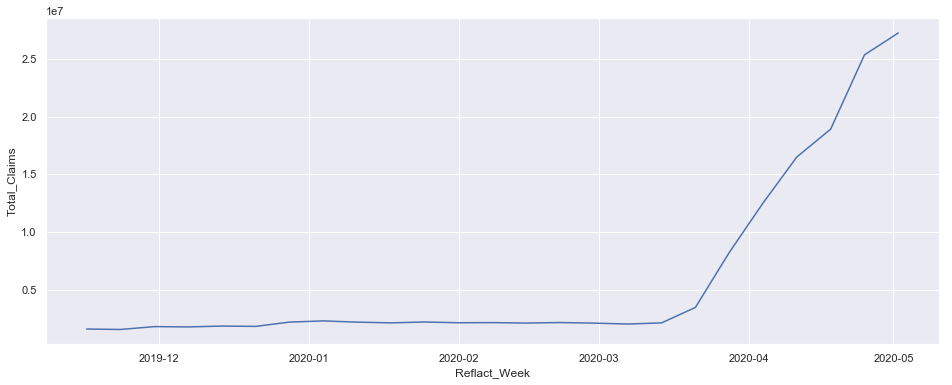

In [144]:
fig, ax = plt.subplots(figsize=(16, 6))
a=sns.lineplot(data=unemp_ins, x='Reflact_Week', y='Total_Claims')